Railway Knowledge System with rinna
===

Ren Nakagawa

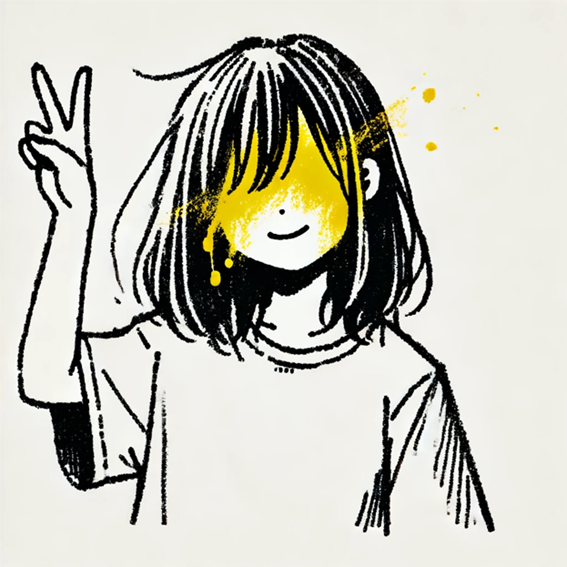

made by DALL-E 3

# Introduction

2015年に女子高生AIとしてLINEに登場し話題になったりんなは、今回鉄道ナレッジシステムに転職しました🚂✨。

AI女子高生りんなは、Microsoftが開発したAIチャットボットで、日本の女子高校生を模したキャラクターです👧🎓。りんなは、LINEを通じてユーザーと会話し、日常の雑談や質問に答えることで、まるで本物の女子高生と話しているような体験を提供します💬😊。

今回、りんなを使って鉄道ナレッジシステムを構築しました🛠️🚉。このシステムは、りんなの自然な対話能力を活かし、鉄道に関する質問や情報提供を人間に尋ねるように行うことができます🗣️💡。

# Lecture

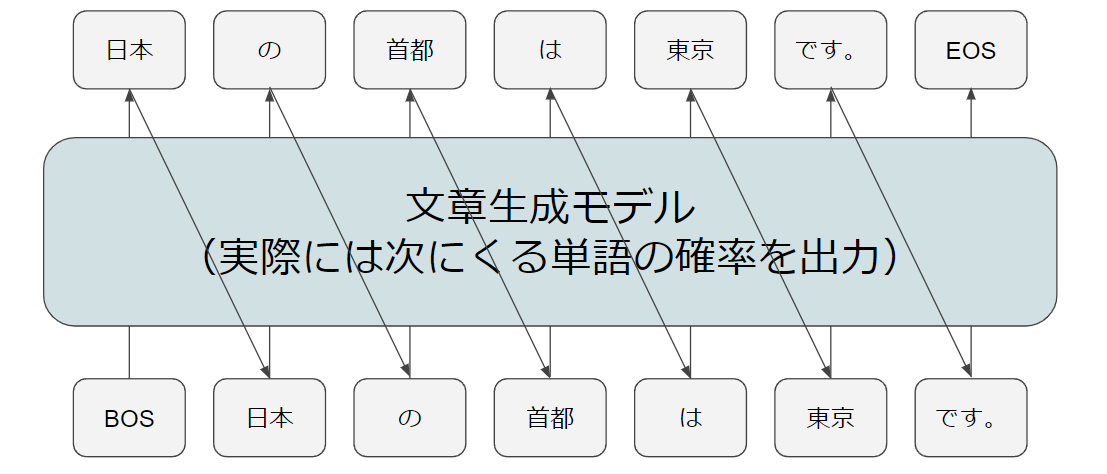

### 文章生成モデルとは
> 文章生成モデルは、単語列に対して次にくる単語を予測する構造をしています。例えば`「日本」「の」「首都」「は」`という単語列を文章生成モデルに入力をすると、次にくる単語は`「東京」`と予測し、`「日本」「の」「首都」「は」「東京」`という単語列を入力をすると、次にくる単語は`「です」`と予測します。

> これは数式で表すと、次にくる単語を`ｘ`として`Ｐ（ｘ；日本，の，首都，は）`という条件付き確率を計算し，様々な単語ｘについて計算される条件付き確率`Ｐ1（東京；日本，の，首都，は）＝0.7`、`Ｐ2（パリ；日本，の，首都，は）＝0.2`、`Ｐ3（きゅうり；日本，の，首都，は）＝0.01`・・・と出力されるなかで最大値をもつ条件付き確率`Ｐ1（東京；日本，の，首都，は）`を取り出す操作によって実現しています。

> すなわち文章生成モデルは条件付き`確率Ｐ（次にくる単語；今までの単語）`を語彙単語分計算する関数であると解釈することができます。
その条件付き確率の列から最大値を持つ単語を取り出すことで次の単語を予測することができ、そのループを行うことで文章を生成することができます。

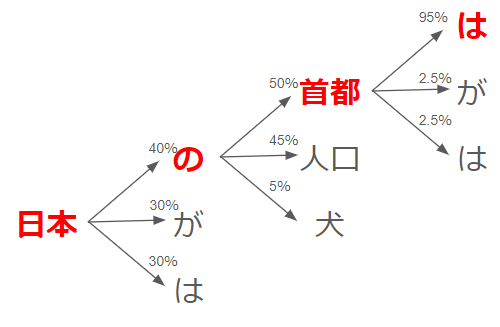

### ざっくりTransformer
> Transformerは、自然言語処理の革新的なモデルで、エンコーダーとデコーダーの2つの部分から成り立ちます。

> エンコーダーは入力文章を内部表現に変換し、デコーダーはその情報を基に新しい文章を生成します。

> Transformerの特徴はAttentionメカニズムを使用することで、文章全体の文脈を捉えつつ重要な部分に重点を置いて処理できる点にあります。また、Multi-Head Attentionにより各単語が文中の他の全単語に複数の視点から注意を払うことが可能です。さらに、位置エンコーディングによって単語の順序情報も加味され、並列処理が可能で高速かつ長距離依存の関係性も効果的に学習できます。

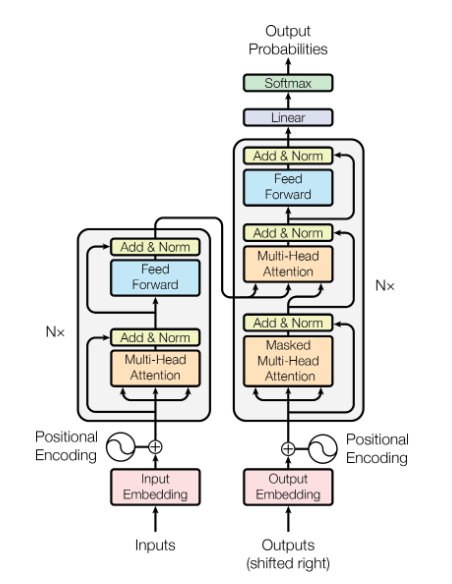

Attention Is All You Need

### BARTとGPT
> 文章生成モデルには大きくBART（Bidirectional and Auto-Regressive Transformers）型とGPT（Generative Pre-trained Transformer）型があります。
  
> BART型は、エンコーダーとデコーダーの両方を備えた構造をしており、入力文章の補完や要約などに強みがあります。BERT型の日本語LLMにはcl-tohoku/bert-base-japaneseがあり、日本語Wikipedeiaで学習したモデルです。

>GPT型はデコーダーのみを使用し、与えられたプロンプトに基づいて続きの文章を生成することに特化しています。GPT型の日本語LLMにはrinna/japanese-gpt2-mediumがあり、Japanese-CC-100と日本語Wikipediaで学習したモデルです。

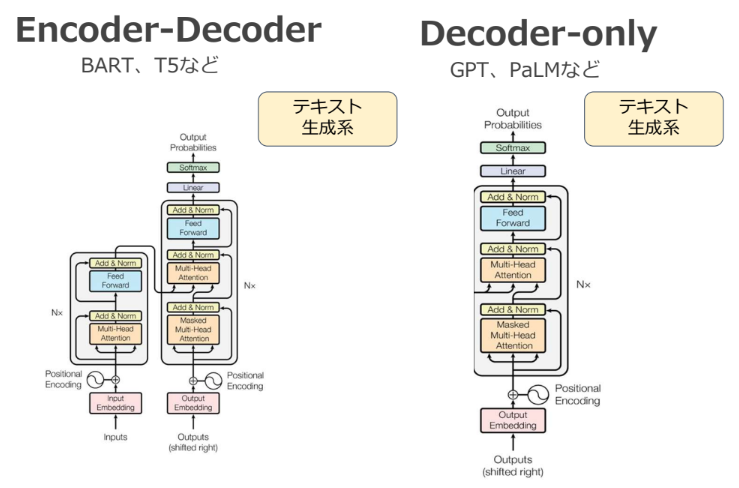

LLM 大規模言語モデル講座 講義資料 © 2023 by 東京大学松尾研究室 is licensed under CC BY-NC-ND 4.0

## 文章生成モデルの応用方法

Why RAG?

### 文章生成モデルの応用レベル
> 目的に特化させたLLMを構築する方法は大きくに4段階に分けることができる。  

- プロンプトエンジニアリング
- 外部ツールの利用
- ファインチューニング
- 事前学習

> 今回は「プロンプトエンジニアリング」と「外部ツールの利用」の2つを利用する。具体的には「鉄道に関する技術上の基準を定める省令の解釈基準」という資料をLLMを用いてベクトル列に変換しベクトルデータベースとして保存する。  
ベクトルデータベースとプロンプトとの関連度を検索しデータベースから関連部分のみを抽出してプロンプトにコンテキストとして加えるようなナレッジ検索システムを構築する。

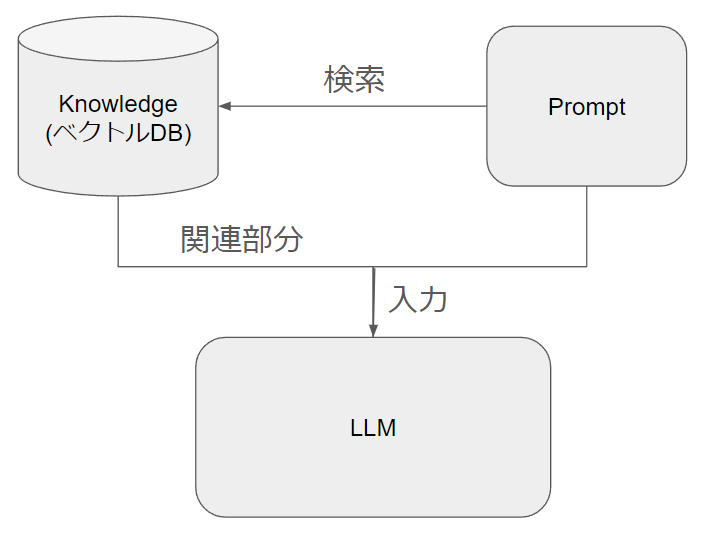

# Demo

## Set up environment

In [1]:
!git clone https://github.com/rakawanegan/pbl-railway-knowledge-system
%cd pbl-railway-knowledge-system
%pip install transformers faiss-gpu fugashi ipadic >> install.txt

Cloning into 'pbl-railway-knowledge-system'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 101 (delta 35), reused 86 (delta 22), pack-reused 0
Receiving objects: 100% (101/101), 443.31 KiB | 3.69 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/pbl-railway-knowledge-system


## Import modules

In [2]:
from glob import glob
import markdown
from bs4 import BeautifulSoup
import torch
import faiss # Facebook AI Similarity Search
from transformers import AutoTokenizer, AutoModel, GPT2Tokenizer, GPT2LMHeadModel

## Set up dataset

In [3]:
!rm data.md
for file in sorted(glob('data/*.md')):
    print(file)
    !cat {file} >> data.md
    !echo "" >> data.md

rm: cannot remove 'data.md': No such file or directory
data/01.md
data/02.md
data/04.md
data/05.md
data/09.md


## Load dataset

In [4]:
def load_markdown_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

markdown_text = load_markdown_file('data.md')
print(markdown_text)

# 1. 総則
## 1.1 第3条(実施基準)関係

### 1.1.1 
鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、省令の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。
実施基準の項目は、省令等の項目に対応したものとし、内容は、解釈基準により示された例示、設計方法、検証方法等に準じて、数値化する等具体的に示すこととする。

### 1.1.2 
実施基準は、本解釈基準を参考に定めるものとするが、技術的実績に応じ、実証データによる確認や理論解析等客観的な検討方法により、鉄道事業者が省令への適合を証明した場合には、本解釈基準によらない構造等を妨げないものであり、届出をする際にその根拠等について説明をすることとする。
ただし、廃止前の普通鉄道構造規則、新幹線鉄道構造規則、特殊鉄道構造規則、新幹線鉄道運転規則及び鉄道運転規則(以下「旧省令」という。)において、特別の構造又は取扱いの許可(以下「特別許可」という。)を受け、又は附則に基づく経過措置により、特別許可を受けたものとみなされた施設、車両及び取扱いであって、この解釈基準に適合しないものについては、この限りでない。

### 1.1.3 
2ただし書の施設、車両及び取扱いのうち、旧省令の施行後最初に行う改築又は改造の工事が完成するまでの間、特別許可を受けたものとみなされたものについては、省令の施行後において改築又は改造することを前提にするものとそれ以外のものとに整理し、経過措置あるいは条件を付した基準とするなどの方法により、実施基準に規定するものとすること。

### 1.1.4
2ただし書の施設、車両及び取扱い(3の施設、車両及び取扱いを除く。)については、旧省令と異なる構造とすることとしたときの条件を考慮して、条件を付した基準とするなどの方法により、実施基準に規定するものとすること。

## 1.2 第5条(危害の防止)関係
のり切り、切土、掘削、盛土、くい打ち等の土砂の掘削等を伴う鉄道の工事にあたっては、工事中及び存続期間中に土砂崩壊、陥没、排土すべり出し等によって人に危害を及ぼさないように工事を行うこと。

## 1.3 第6条(著しい騒音の防止)関係
### 1.3.1
新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)による

## RAG(retrieval augmented generation)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
model = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese")

def embed_text(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings.numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [6]:
emb = embed_text(['安全・安心な鉄道輸送の維持に向け、国土交通省はさまざまな情報を公開している。'])
print(emb.shape)
print()
print(emb)

(1, 768)

[[ 2.35450894e-01 -8.96722600e-02 -9.49342176e-02  8.57493505e-02
  -4.72914986e-02  1.09325516e+00  9.39331353e-02  1.35543287e-01
  -4.45025623e-01 -5.41056395e-01 -3.36215720e-02 -6.84493706e-02
   1.89359002e-02  3.86482477e-01 -1.30605558e-02  2.03806192e-01
  -1.39382586e-01 -5.20241559e-01 -1.49258092e-01 -1.14671970e-02
  -4.21623848e-02 -5.49967773e-02  5.76097071e-02  7.01275617e-02
  -1.23606242e-01 -8.79746228e-02 -2.49906749e-01  1.34349555e-01
   3.14442873e-01 -6.85880110e-02  1.90720364e-01  1.42175823e-01
  -1.30729387e-02  4.18568492e-01  2.45974258e-01  3.77085656e-01
   1.73258826e-01  3.03281873e-01  1.25731960e-01  1.58805594e-01
  -2.94065736e-02 -9.29155946e-02  4.48404670e-01  6.63364902e-02
  -5.00097573e-01  5.00147929e-03 -1.65162403e-02 -2.91508287e-01
   1.69307798e-01 -5.56728303e-01 -1.90632820e-01  1.09798089e-01
   1.49958972e-02  3.45879972e-01 -1.39213175e-01 -2.58095473e-01
   9.76742983e-01  3.42820346e-01 -2.52488256e-01 -9.03847143e-02


In [7]:
# https://huggingface.co/tohoku-nlp/bert-base-japanese
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
sentences = markdown_text.split('\n')
embeddings = embed_text(sentences)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [9]:
query = "新幹線の騒音防止に関する基準は？"
query_embedding = embed_text([query])

k = 2 # number of context
distances, indices = index.search(query_embedding, k)

context = " ".join([sentences[i] for i in indices[0] if i < len(sentences)])
prompt = f"Context: {context}\nQ: {query}\nA:"
print(prompt)

Context: 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。
Q: 新幹線の騒音防止に関する基準は？
A:


In [10]:
del tokenizer, model

## Inference

In [11]:
tokenizer = AutoTokenizer.from_pretrained("rinna/japanese-gpt2-medium")
model = GPT2LMHeadModel.from_pretrained("rinna/japanese-gpt2-medium")

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/806k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

In [12]:
# https://huggingface.co/rinna/japanese-gpt2-medium
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(32000, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=32000, bias=False)
)


In [13]:
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
outputs = model.generate(
    input_ids,
    max_length=1000,
    num_return_sequences=1,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.pad_token_id,
    no_repeat_ngram_size=2,
)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
answer = answer[len(prompt)-2:].replace('。', '。\n')
context = context.replace('。', '。\n')
total_output = \
f'''
query:
{query}

answer:
{answer}

evidence:
{context}
'''

print(total_output)


query:
新幹線の騒音防止に関する基準は？

answer:
新幹線車両の騒音は新幹線車両に与える影響が大きいので、騒音対策は必要である。
しかし、東海道新幹線車両の音は騒音規制の対象とはならない。
新幹線車両が騒音を規制するには新幹線騒音基準を定める必要がある。
この基準を満たさない騒音が新幹線列車に発生すると、その騒音により新幹線が運行に支障を生じ、運行の継続が危ぶまれる。
このような事態を防止するため、jr東日本では、平成17年3月31日、鉄道旅客の鉄道事業における騒音に関する規制の見直しに関する検討会(第1回)を開催し、検討結果を報告している。
 この基準に適合しない騒音が発生すると新幹線の運行に重大な支障が生じるおそれがある。
そのため、国土交通省では新幹線列車の騒音に係る規制を平成18年4月1日から施行する。
なお、この規制は平成19年1月30日まで延長された。
 なお、本改正は公布の日から起算して1年を超えない範囲内において政令で定める日から適用するものとする。
 本改正の施行日は政令の公布日(平成20年2月28日)とする(施行規則第2条)。
 また、改正後の新幹線車両は、車両重量が1トンを超える車両については、「新幹線用車両」として、最高速度が100km毎時を超える車両の区分を廃止する(新幹線用の車両区分廃止)とともに、車両の重量を1. 5トン以下にする措置を講ずること。
 (3) 車両総重量の10%を超える貨物自動車(貨物積載車を除く。
以下同じ。
。
次条において同じ)を運転する車両(以下「貨物車」という。
第3条に規定する貨物車は除く。
 第4条 貨物車の区分は貨物の積載量に応じて区分するものであり、貨物を積載する車両の積載量は、次のとおりとするものとする(同条ただし書において「積載量の区分」とは、積載の区分をいう。
 2 ) 第5条の規定による貨物車両の貨物積卸しの方法については次のとおりとし、当該貨物車両を貨物として積載し、又は貨物貨物と貨物の間に貨物又は荷物を挟むことができる貨物車を積載した貨物車が積載される貨物貨車については積載荷重を、また貨物に貨物以外の貨物(ただし貨物でない貨物を含む。
 以下同じ 。
 3 において同様とする)又はその積載物とを混合して積載することができる貨物車で積載された貨物車両は積載重量をそれぞれ1キロ又

最終的な出力までこのNotebookで得られることを期待してGPT2の日本語版であるりんなを用いて実装しました。  

しかし、ローカルLLMは実装上の難点が多く本作品は実運用には至らない結果です。

そのため自分のデータセットでナレッジ検索システムを実装したい場合には本作品を用いてプロンプトの作成までを行い、文章の構成はChatGPTなどの外部LLMサービスを利用することを推奨します。

## Wrap up

In [15]:
%reset -f

In [16]:
from tqdm import tqdm
import time
import pandas as pd
from contextlib import contextmanager

from src.main import RailwayKnowledgeSystemWithRinnaGPT2, MakeRailwayKnowledgePromptWithTohokuBERT

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [17]:
query = "新幹線の騒音防止に関する基準は？"

> 新幹線の騒音防止に関する基準は以下の通りです：

> 環境基準と音源対策
新幹線の騒音については、環境省（旧環境庁）による新幹線鉄道に係る環境基準によります。音源対策が騒音の防止または軽減を図る上で最も基本的な施策となります。

> 目標値
東海道、山陽、東北、上越の各新幹線については、当面の目標として沿線の住宅の集合度合いに応じて音源対策を行い、順次75デシベル以下を目指すとされています。

> 測定方法
騒音の測定は、沿線屋外の地上1.2メートルの高さにおいて、騒音のピークレベルのパワー平均値で行います。測定位置は地域の騒音を代表する地点として、近接側軌道中心線から25メートルの位置を原則とします。ただし、住宅の建築が禁じられている工業専用地域、ほとんど人が住んでいない山林、原野、農耕地は適用外です。

> その他の基準
普通鉄道（新幹線を除く）の新設または大規模改良に際しての騒音レベルは、昼間（7～22時）は60デシベル以下、夜間（22～翌7時）は55デシベル以下とする。
大規模改良の場合は、騒音レベルの状況を改良前より改善する。
この情報は、提供されたドキュメントの「1.3 第6条（著しい騒音の防止）関係」から抽出されました。

made by GPTs with 鉄道に関する技術上の基準を定める省令の解釈基準  
(PDF modified to Markdown by Nakagawa.)

In [18]:
with timer("set up"):
    rks = RailwayKnowledgeSystemWithRinnaGPT2(k=5)
with timer("make prompt"):
    prompt = rks.make_prompt(query)
with timer("inference"):
    total_output = rks.inference(query)
print('-'*50)
print(prompt)
print('-'*50)
print(total_output)

[set up] done in 2 s
[make prompt] done in 0 s
[inference] done in 95 s
--------------------------------------------------
Context: 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全 無軌条電車以外の鉄道のプラットホームの有効長は、当該プラットホームに発着する列車の最も前方にある旅客車から最も後方にある旅客車（車両に直接接続する形式のホームドアを設ける場合においては、列車の最も前方にある乗降口の前端から最も後方にある乗降口の後端）までの長さのうち最長のものの長さ以上であって、かつ、旅客の安全及び円滑な乗降に支障を及ぼすおそれのないものであること。ただし、当該プラットホームにおける乗降人員が少ない場合であって、列車の運用上やむを得ない場合にあっては、ドア非扱いを行い、かつ、案内放送を行う等の旅客の転落等の危険を防止するための措置を講ずることによりプラットホームの有効長を発着する列車長に対して短くすることができる。 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 １の係員に対する教育及び訓練の実施、適性、知識及び技能の確認は、当該係員の所属する鉄道事業者（係員が所属している事業者が鉄道事業者以外の場合にあっては、当該作業を委託した鉄道事業者。以下同じ。）が実施要領を定めて行うこととする。ただし、教育及び訓練の実施、

In [19]:
with timer("set up"):
    mrp = MakeRailwayKnowledgePromptWithTohokuBERT(k=2)
with timer("make prompt"):
    prompt = mrp.make_prompt(query)
with timer("inference"):
    total_output = rks.generate_answer(prompt)
print('-'*50)
print(prompt)
print('-'*50)
print(total_output)

[set up] done in 139 s
[make prompt] done in 0 s
[inference] done in 147 s
--------------------------------------------------
Context: 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全
Query: 新幹線の騒音防止に関する基準は？
Answer:
--------------------------------------------------



In [20]:
df = pd.read_csv("data/Question.csv")
df.head()

,章,種類,問題,答え
0,1,穴埋め問題,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、____の範囲内で個々...,実施基準
1,1,穴埋め問題,新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが...,75
2,1,短答問題,鉄道事業者は何に基づいて詳細な実施基準を策定する必要がありますか？,実施基準
3,1,短答問題,新幹線の騒音基準は何デシベル以下を目標としていますか？,75デシベル以下
4,1,抽象問題,実施基準を策定する際に鉄道事業者が考慮すべき重要な点は何ですか？,実施基準を策定する際には、鉄道事業者は個々の鉄道事業者の実状を反映し、省令等の項目に対応した...


In [ ]:
df_answer = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    row = dict(row)
    query = row["問題"]
    rks_prompt = rks.make_prompt(query)
    mrp_prompt = mrp.make_prompt(query)
    rks_answer = rks.generate_answer(rks_prompt)
    mrp_answer = rks.generate_answer(mrp_prompt)
    dict_result = {
        "rks_prompt": rks_prompt,
        "mrp_prompt": mrp_prompt,
        "rks_answer": rks_answer,
        "mrp_answer": mrp_answer,
    }
    row.update(dict_result)
    df_answer.append(row)
df_answer = pd.DataFrame(df_answer)
df_answer.to_csv("data/Answer.csv", index=False)
df_answer.head()

  6%|▌         | 2/35 [07:46<2:07:00, 230.92s/it]

# Experiments

## LLM list
- GPT4
> aaa
- GPTs
> aaa
- RailwayKnowledgeSystem(BERT) + GPT4
> aaa
- RailwayKnowledgeSystem(Rinna) + GPT4
> aaa

## GPTs setting

Name:  
> PBL-dev-markdown12459  

Description:  
> 対話型鉄道文書検索アシスタント  

Instructions:  
> 対話型文書情報検索・表示機能の開発
 - プロンプトに調べたい内容を入力すると、回答とKnowledge内の根拠箇所を提示する。
 - Knowledgeに記載されていない情報に関してはわからないと答えること。

Knowledge:  
> Markdown file  
(PDF modified to Markdown by Ninomiya.)

Capabilities:  
> Code Interpreter & Data Analysis

## Result

In [ ]:
!cat data/Result.csv

teisei-hyouka

LLM type                                 | Score | Comment|
-----------------------------------------|-------|--------|
GPT4                                     |       |        |
GPTs                                     |       |        |
RailwayKnowledgeSystem(BERT) + GPT4      |       |        |
RailwayKnowledgeSystem(Rinna) + GPT4     |       |        |    

# Discussion

今回用いたモデルはGPT2はパラメータ数が少ないため、残念な文章を生成してしまう結果となりました。一方でプロンプト自体は必要な情報が抽出できているので、本作品の運用としてはプロンプトを本サービスを用いて生成しChatGPTなどの外部LLMサービスに手動またはAPIを用いて入力するのが良いでしょう。

また他にナレッジ検索システムを実装する方法として、GPTsというサービスがあります。GPTsはOpenAIの提供する簡単にカスタムLLMが作成できるサービスで、GPTsを用いることで簡単に目的に特化させたLLMの作成が可能です。

このGPTsとの差別化について、GPTsでも文章の抽出が可能ですがこれはコードの実行結果をプロンプトに入れることのできるOpen Interpleterという機能によるもので、GPTsでは機能を明示的に実行させることが難しいという特徴があります。そのためKnowlegeとしてGPTsにデータを与えても使われないということが発生する可能性があります。
その点で、本作品ではプロンプトを生成する部分に組み込んでいるため、安定して文書の情報を入力することが可能です。
そのため、GPTsと比べて安定した出力が可能であり差別化ができると考えています。

# Reference
```
鉄道に関する技術上の基準を定める省令の解釈基準: https://www.mlit.go.jp/common/001398980.pdf
```

```
cl-tohoku/bert-base-japanese © 2023 Tohoku NLP Group, Tohoku University  is licensed under Apache-2.0 license
```
```
@article{rinna_pretrained2021,
    title={日本語自然言語処理における事前学習モデルの公開},
    author={趙 天雨 and 沢田 慶},
    journal={人工知能学会研究会資料 言語・音声理解と対話処理研究会},
    volume={93},
    pages={169-170},
    year={2021},
    doi={10.11517/jsaislud.93.0_169}
}
```